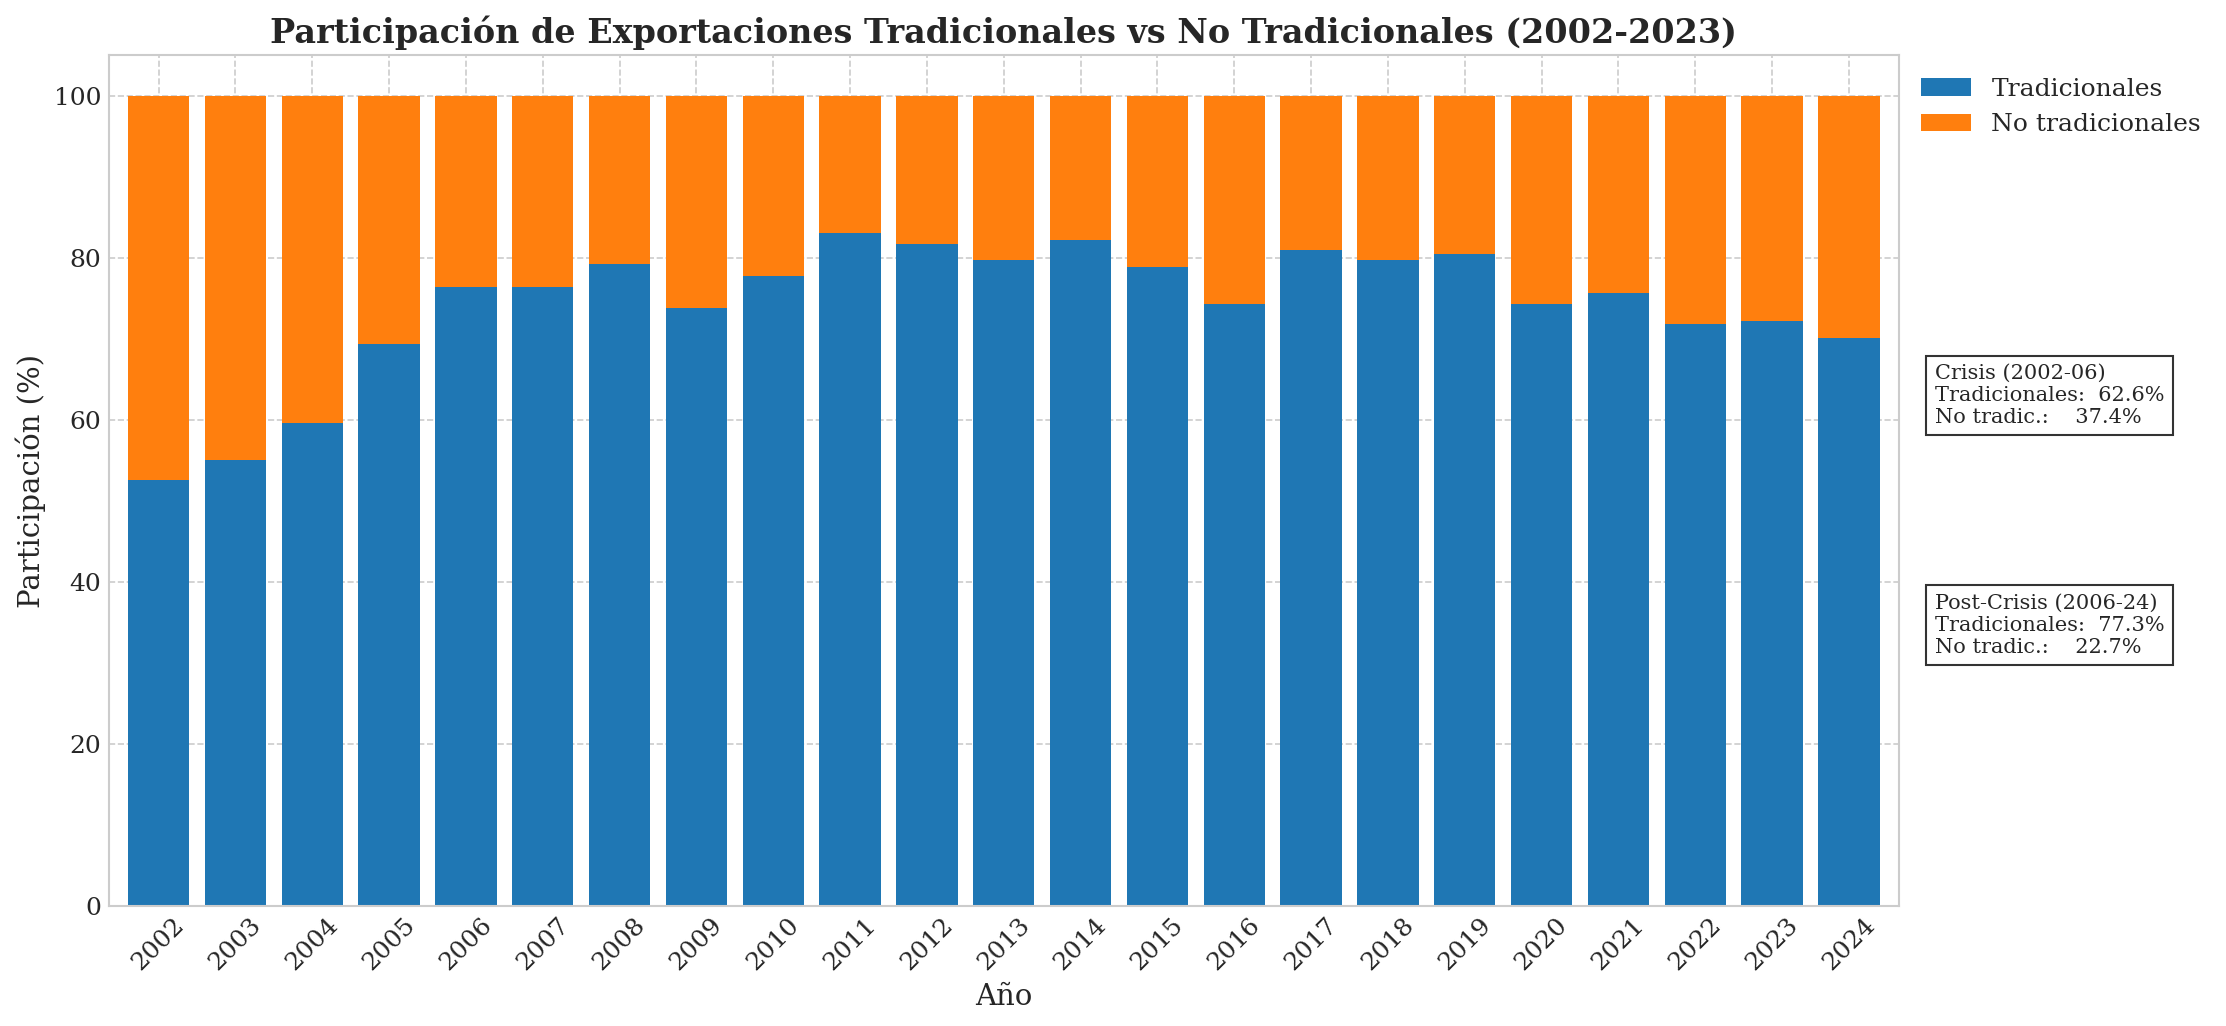

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── 1. Parámetros y rutas ─────────────────────────────────────────────────────
CRISIS_YEARS = slice(2002, 2006)            # 2002-2005 inclusive
POST_YEARS   = slice(2006, 2025)            # 2006-último año (ajusta si añades 2024+)
OUTPUT_DIR   = "../../../assets/tesis/neodesarollismo/serie_completa"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── 2. Estilo profesional ─────────────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16, "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150, "savefig.bbox": "tight"
})

# ── 3. Carga de datos ─────────────────────────────────────────────────────────
with sqlite3.connect("../../../db/proyectomacro.db") as conn:
    df = pd.read_sql_query(
        "SELECT * FROM exportaciones_tradicionales_no_tradicionales", conn
    )

df.set_index("año", inplace=True)
df = df.loc[2002:2024].copy()               # ajusta si tu tabla llega a 2024+

# ── 4. Preparar participaciones (%) ───────────────────────────────────────────
df["total"] = df["tradicionales"] + df["no_tradicionales"]
pct = df[["tradicionales", "no_tradicionales"]].div(df["total"], axis=0) * 100

# ── 5. Estadísticas promedio por periodo ──────────────────────────────────────
avg_crisis = pct.loc[CRISIS_YEARS].mean()
avg_post   = pct.loc[POST_YEARS].mean()

# ── 6. Gráfico stacked-bar por año ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 7))
pct.plot(kind="bar", stacked=True, ax=ax, width=0.8)

ax.set_ylabel("Participación (%)")
ax.set_xlabel("Año")
ax.set_title("Participación de Exportaciones Tradicionales vs No Tradicionales (2002-2023)",
             fontweight="bold")
ax.legend(["Tradicionales", "No tradicionales"], loc="upper left",
          bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

# ── 7. Cuadros con promedios de crisis y post-crisis ──────────────────────────
stats_crisis = (
    f"Tradicionales:  {avg_crisis['tradicionales']:.1f}%\n"
    f"No tradic.:    {avg_crisis['no_tradicionales']:.1f}%"
)
stats_post = (
    f"Tradicionales:  {avg_post['tradicionales']:.1f}%\n"
    f"No tradic.:    {avg_post['no_tradicionales']:.1f}%"
)

ax.text(1.02, 0.60, "Crisis (2002-06)\n" + stats_crisis,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))
ax.text(1.02, 0.33, "Post-Crisis (2006-24)\n" + stats_post,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

# ── 8. Guardar y mostrar ──────────────────────────────────────────────────────
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "participacion_exportaciones_2002_2023.png"),
            dpi=300)
plt.show()

# ── 9. Verificación rápida ────────────────────────────────────────────────────
assert abs(pct.sum(axis=1) - 100).max() < 1e-6, "Las participaciones no suman 100%"
